# Unit 5 - Financial Planning

In [1]:
# Initial imports
import os
import requests
import pandas as pd
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
from MCForecastTools import MCSimulation
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
import sys

%matplotlib inline

In [2]:
# Load .env enviroment variables; stop with error if file not found
if not load_dotenv():
    sys.exit("Error: .env file not found")
    

In [3]:
def get_stock_data(syms,start,end):
    #call alpaca with list of symbols, start date, and end date to get daily pricing\volume details
    #default timeframe to 1 Day
    timeframe = "1Day"
    return api.get_bars(
        syms,
        timeframe,
        start,
        end
    ).df

In [4]:
def calc_print_value(amt,sym,price):
    #take in the number of shares (amt), the stock symbol, and the current price
    #calculate and print the value of those shares
    value = round((amt * price),2)
    print(f"The current value of your {amt} {sym} is ${value:0.2f}")
    return value
    

In [5]:
def configure_mc_simu(df,num_yrs):
    # configure a monte carlo simulation for two stocks; assume 40% and 60% weights
    # derive the number of trading days based on the number of years requested
    return MCSimulation(
    portfolio_data = df,
    weights = [.40,.60],
    num_simulation = 500,
    num_trading_days = 252*num_yrs
)

In [6]:
def process_ci(table,init_invest,yrs):
    # take in the summary table for the MC simulation, the amount of the initial investment, and the
    # number of years (years used for display purposes only)
    # Calculate and print the 95% control interval
    # Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of the investment
    ci_lower = round(table.iloc[8]*init_invest,2)
    ci_upper = round(table.iloc[9]*init_invest,2)

    # Print results
    print(f"There is a 95% chance that an initial investment of ${init_invest:,} in the portfolio"
      f" over the next {yrs} years will end within in the range of"
      f" ${ci_lower:,} and ${ci_upper:,}")

In [7]:
def print_summary_stats(mc_simu):
    # Create, print, and return a table of summary statistics
    tbl = mc_simu.summarize_cumulative_return()
    # Print summary statistics
    print(tbl)
    return tbl

## Part 1 - Personal Finance Planner

### Collect Crypto Prices Using the `requests` Library

In [8]:
# Set current amount of crypto assets
my_btc=1.2
my_eth=5.3

In [9]:
# Crypto API URLs
btc_url = "https://api.alternative.me/v2/ticker/Bitcoin/?convert=USD"
eth_url = "https://api.alternative.me/v2/ticker/Ethereum/?convert=USD"

In [10]:
# Fetch current BTC price
btc_data = requests.get(btc_url).json()
if len(btc_data) == 0:
    sys.exit("Error: btc_data file is empty")

# Fetch current ETH price
eth_data = requests.get(eth_url).json()
if len(eth_data) == 0:
    sys.exit("Error: eth_data file is empty")

# Compute current value of my crpto
btc_price = btc_data['data']['1']['quotes']['USD']['price']
eth_price = eth_data['data']['1027']['quotes']['USD']['price']

#call function to calculate and print balance for crypto wallet
my_btc_value = calc_print_value(my_btc,'BTC',btc_price)
my_eth_value = calc_print_value(my_eth,'ETH',eth_price)


The current value of your 1.2 BTC is $75626.40
The current value of your 5.3 ETH is $16282.92


### Collect Investments Data Using Alpaca: `SPY` (stocks) and `AGG` (bonds)

In [11]:
# Set current amount of shares
my_agg = 200
my_spy = 50

In [12]:
# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

# Create the Alpaca API object
api = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version = "v2"
)

In [13]:
# Format current date as ISO format
start_date = pd.Timestamp("2020-05-01", tz="America/New_York").isoformat()
end_date = pd.Timestamp("2020-05-01", tz="America/New_York").isoformat()

# Set the tickers
tickers = ["AGG", "SPY"]

# Get current closing prices for SPY and AGG
ticker_data = get_stock_data(tickers,start_date,end_date)

# Reorganize the DataFrame
# Separate ticker data
agg_df = ticker_data.iloc[0]
spy_df = ticker_data.iloc[1]

# Concatenate the ticker DataFrames
combined = pd.concat([agg_df,spy_df],axis=1,keys=['AGG','SPY'])

# Preview DataFrame
combined
                     

,AGG,SPY
close,116.87,282.83
high,117.0998,290.6572
low,116.6775,281.52
trade_count,24394,639155
open,116.97,285.31
volume,6331654,127002350
vwap,116.846992,284.074074
symbol,AGG,SPY


In [14]:
# Pick AGG and SPY close prices
agg_close_price = combined['AGG']['close']
spy_close_price = combined['SPY']['close']

# Print AGG and SPY close prices
print(f"Current AGG closing price: ${agg_close_price}")
print(f"Current SPY closing price: ${spy_close_price}")

Current AGG closing price: $116.87
Current SPY closing price: $282.83


In [15]:
# Compute and print the current value of shares
my_spy_value = calc_print_value(my_spy,'SPY',spy_close_price)
my_agg_value = calc_print_value(my_agg,'AGG',agg_close_price)

The current value of your 50 SPY is $14141.50
The current value of your 200 AGG is $23374.00


### Savings Health Analysis

In [16]:
# Set monthly household income
monthly_income = 12000

# Consolidate financial assets data
savings_data = [my_btc_value + my_eth_value,my_spy_value + my_agg_value]
#savings_data

# Create savings DataFrame
savings_df = pd.DataFrame(savings_data,columns=['amount'],index=['crypto','stock/bond'])

# Display savings DataFrame
display(savings_df)

,amount
crypto,91909.32
stock/bond,37515.50


<Axes: title={'center': 'Composition of Personal Savings'}, ylabel='amount'>

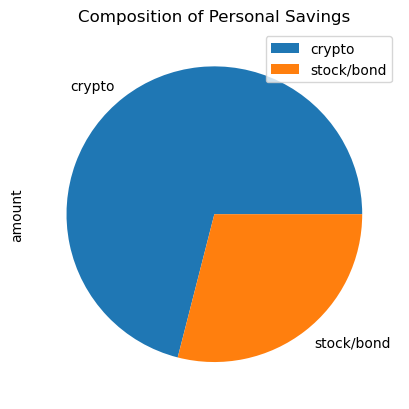

In [17]:
# Plot savings pie chart
savings_df.plot.pie(y='amount',title='Composition of Personal Savings')


In [18]:
# Set ideal emergency fund
emergency_fund = monthly_income * 3

# Calculate total amount of savings
total_savings = savings_df['amount']['crypto'] + savings_df['amount']['stock/bond']
#total_savings

# Validate saving health
if total_savings > emergency_fund:
    print(f"Congratulations! Your savings of ${total_savings} exceeds your emergency fund needs of ${emergency_fund}")
elif total_savings == emergency_fund:
    print(f"Congratulations! Your savings of ${total_savings} matches your emergency fund needs of ${emergency_fund}")
else:
    print(f"Uh oh, your savings of ${total_savings} is below your emergency fund needs of ${emergency_fund} by ${emergency_fund-total_savings}")


Congratulations! Your savings of $129424.81999999999 exceeds your emergency fund needs of $36000


## Part 2 - Retirement Planning

### Monte Carlo Simulation

In [19]:
# Set start and end dates of five years back from today.
# Sample results may vary from the solution based on the time frame chosen
start_date = pd.Timestamp('2016-05-01', tz='America/New_York').isoformat()
end_date = pd.Timestamp('2021-05-01', tz='America/New_York').isoformat()

In [20]:
# Get 5 years' worth of historical data for SPY and AGG
# recall Tickers still set to AGG and SPY:
five_yr_ticker_data = get_stock_data(tickers,start_date,end_date)
#five_yr_ticker_data

# Reorganize the DataFrame
# Separate ticker data
agg = five_yr_ticker_data[five_yr_ticker_data['symbol']=='AGG'].drop('symbol', axis=1)
spy = five_yr_ticker_data[five_yr_ticker_data['symbol']=='SPY'].drop('symbol', axis=1)

# Concatenate the ticker DataFrames
df_stock_data = pd.concat([agg,spy],axis=1,keys=['AGG','SPY'])

# Display sample data
df_stock_data.head()



AGG                                          \
                             close      high       low trade_count    open   
timestamp                                                                    
2016-05-02 04:00:00+00:00  110.605  110.7400  110.5200       15122  110.74   
2016-05-03 04:00:00+00:00  110.810  110.9450  110.7500       15663  110.89   
2016-05-04 04:00:00+00:00  110.860  110.9315  110.7595       13984  110.91   
2016-05-05 04:00:00+00:00  111.140  111.1600  110.8010       15708  110.92   
2016-05-06 04:00:00+00:00  110.970  111.1200  110.9700       12697  111.12   

                                                     SPY                  \
                            volume        vwap     close    high     low   
timestamp                                                                  
2016-05-02 04:00:00+00:00  3608552  110.626939  207.9700  208.18  206.41   
2016-05-03 04:00:00+00:00  3128774  110.864495  206.1592  206.80  205.28   
2016-05-04 04:00:00+00:00  3096337  110.877983  205.0100  205.85  204.42   
2016-05-05 04:00:00+00:00  3052967  111.030002  204.9700  205.98  204.47   
2016-05-06 04:00:00+00:00  2922700  111.027631  205.7200  205.77  203.88   

                                                                      
                          trade_count    open     volume        vwap  
timestamp                                                             
2016-05-02 04:00:00+00:00      263586  206.92   64747229  207.305695  
2016-05-03 04:00:00+00:00      377523  206.52  108050343  206.309997  
2016-05-04 04:00:00+00:00      345266  204.99   94995641  205.086315  
2016-05-05 04:00:00+00:00      280626  205.56   68425268  205.140615  
2016-05-06 04:00:00+00:00      340162  204.06   90999800  204.943796

In [21]:
# Configuring a Monte Carlo simulation to forecast 30 years cumulative returns
MC_thirty_year = configure_mc_simu(df_stock_data,30)

In [22]:
# Printing the simulation input data
df_stock_data

AGG                                          \
                             close      high       low trade_count    open   
timestamp                                                                    
2016-05-02 04:00:00+00:00  110.605  110.7400  110.5200       15122  110.74   
2016-05-03 04:00:00+00:00  110.810  110.9450  110.7500       15663  110.89   
2016-05-04 04:00:00+00:00  110.860  110.9315  110.7595       13984  110.91   
2016-05-05 04:00:00+00:00  111.140  111.1600  110.8010       15708  110.92   
2016-05-06 04:00:00+00:00  110.970  111.1200  110.9700       12697  111.12   
...                            ...       ...       ...         ...     ...   
2021-04-26 04:00:00+00:00  114.650  114.8015  114.6500       13521  114.74   
2021-04-27 04:00:00+00:00  114.370  115.1300  114.3700       12734  115.13   
2021-04-28 04:00:00+00:00  114.430  114.4685  114.2000       24329  114.45   
2021-04-29 04:00:00+00:00  114.370  114.3700  114.0900       21243  114.14   
2021-04-30 04:00:00+00:00  114.490  114.5150  114.3300       19584  114.41   

                                                     SPY                    \
                            volume        vwap     close    high       low   
timestamp                                                                    
2016-05-02 04:00:00+00:00  3608552  110.626939  207.9700  208.18  206.4100   
2016-05-03 04:00:00+00:00  3128774  110.864495  206.1592  206.80  205.2800   
2016-05-04 04:00:00+00:00  3096337  110.877983  205.0100  205.85  204.4200   
2016-05-05 04:00:00+00:00  3052967  111.030002  204.9700  205.98  204.4700   
2016-05-06 04:00:00+00:00  2922700  111.027631  205.7200  205.77  203.8800   
...                            ...         ...       ...     ...       ...   
2021-04-26 04:00:00+00:00  3687396  114.703085  417.6100  418.22  416.8111   
2021-04-27 04:00:00+00:00  3962274  114.493905  417.5200  418.14  416.3000   
2021-04-28 04:00:00+00:00  7411127  114.382062  417.4000  419.01  416.9000   
2021-04-29 04:00:00+00:00  6709216  114.258020  420.0600  420.72  416.4400   
2021-04-30 04:00:00+00:00  7705463  114.461660  417.3000  418.54  416.3400   

                                                                      
                          trade_count    open     volume        vwap  
timestamp                                                             
2016-05-02 04:00:00+00:00      263586  206.92   64747229  207.305695  
2016-05-03 04:00:00+00:00      377523  206.52  108050343  206.309997  
2016-05-04 04:00:00+00:00      345266  204.99   94995641  205.086315  
2016-05-05 04:00:00+00:00      280626  205.56   68425268  205.140615  
2016-05-06 04:00:00+00:00      340162  204.06   90999800  204.943796  
...                               ...     ...        ...         ...  
2021-04-26 04:00:00+00:00      297405  417.44   53597096  417.511219  
2021-04-27 04:00:00+00:00      301338  417.93   52112393  417.481640  
2021-04-28 04:00:00+00:00      332655  417.81   51994369  417.739706  
2021-04-29 04:00:00+00:00      452194  420.32   80506526  418.860662  
2021-04-30 04:00:00+00:00      481284  417.63   87467317  417.640930  

[1259 rows x 14 columns]

In [23]:
# Running a Monte Carlo simulation to forecast 30 years cumulative returns
MC_thirty_year.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.008055,1.005934,1.018785,0.991075,0.991336,1.007666,0.994597,1.004617,1.001418,1.001875,...,0.995231,0.987086,0.986372,1.006033,1.006359,1.001863,1.000982,1.005479,0.992392,0.995806
2,1.019697,1.001916,1.020160,0.995878,0.996188,1.003405,1.002023,1.008553,1.008386,1.009657,...,1.004264,0.983881,0.989996,1.016135,1.004564,1.032524,1.011490,1.023252,0.993019,0.996192
3,1.019944,0.996106,1.027462,1.002187,1.007918,1.012544,1.002896,1.023181,1.007319,1.013953,...,1.008605,0.986247,0.988905,1.014088,1.005356,1.032373,1.016262,1.017261,0.999137,0.993756
4,1.012973,0.995640,1.033805,1.006223,1.007087,1.011471,0.993066,1.030130,0.989839,1.015098,...,1.021881,0.978621,0.990800,1.021456,1.010183,1.037312,1.008457,1.005494,0.982138,1.003307
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7556,24.045539,17.282676,13.314655,7.305593,13.471329,8.842776,10.167243,11.960197,21.241031,16.721434,...,18.001275,52.305481,14.092431,19.672832,6.782519,36.722394,18.357802,10.562645,69.595791,81.579002
7557,23.964287,17.289774,13.359405,7.309107,13.340584,8.951787,10.137189,12.167032,21.674850,16.843896,...,18.021590,52.517847,14.001136,19.685219,6.750824,36.450793,18.399882,10.518240,68.927678,81.214823
7558,24.020527,17.275841,13.439671,7.308092,13.355812,8.929977,10.134439,12.048653,21.480951,16.814110,...,18.078118,51.917828,13.938874,19.586650,6.736784,36.629719,18.485104,10.410289,68.577639,81.598429
7559,24.297018,17.408232,13.446673,7.363965,13.420934,8.884442,9.995088,12.142312,21.460331,16.807701,...,17.814328,51.691478,13.872508,19.765098,6.781844,36.995596,18.526375,10.220912,67.980110,80.361939


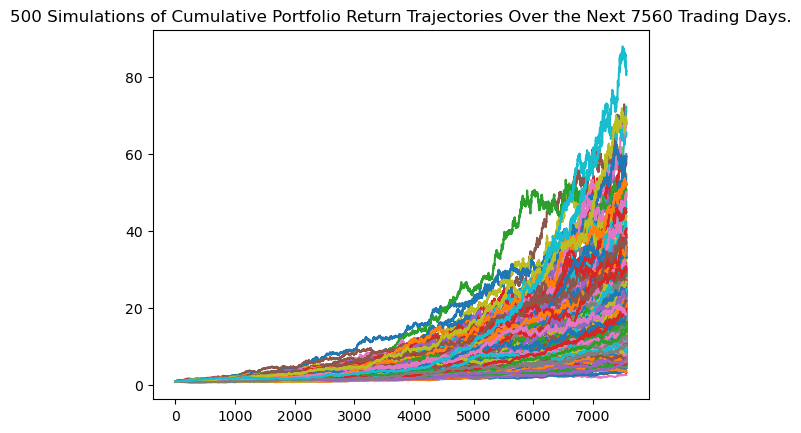

In [24]:
# Plot simulation outcomes
line_plot = MC_thirty_year.plot_simulation()

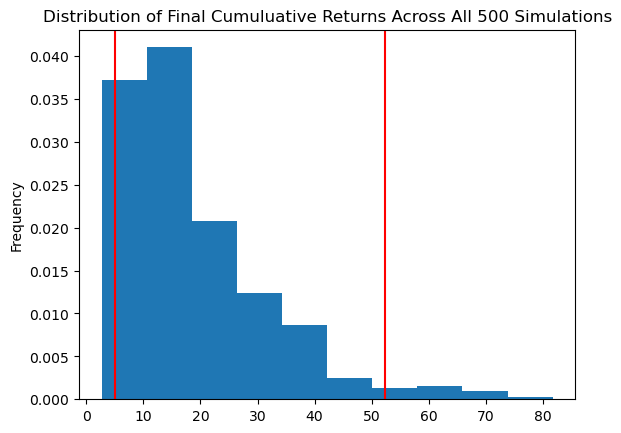

In [25]:
# Plot probability distribution and confidence intervals
dist_plot = MC_thirty_year.plot_distribution()


### Retirement Analysis

In [26]:
# Fetch and print summary statistics from the Monte Carlo simulation results
tbl = print_summary_stats(MC_thirty_year)

count           500.000000
mean             18.825412
std              12.625115
min               2.691118
25%               9.879646
50%              15.408726
75%              24.191353
max              81.710437
95% CI Lower      5.038227
95% CI Upper     52.251214
Name: 7560, dtype: float64


### Calculate the expected portfolio return at the `95%` lower and upper confidence intervals based on a `$20,000` initial investment.

In [27]:
# Set initial investment
initial_investment = 20000

# print details for investment at 30 years with 95% confidence interval
process_ci(tbl,initial_investment,'30')


There is a 95% chance that an initial investment of $20,000 in the portfolio over the next 30 years will end within in the range of $100,764.53 and $1,045,024.28


### Calculate the expected portfolio return at the `95%` lower and upper confidence intervals based on a `50%` increase in the initial investment.

In [28]:
# Update initial investment
initial_investment = 20000 * 1.5

# print details for investment at 30 years with 95% confidence interval
process_ci(tbl,initial_investment,'30')

There is a 95% chance that an initial investment of $30,000.0 in the portfolio over the next 30 years will end within in the range of $151,146.8 and $1,567,536.43


## Optional Challenge - Early Retirement


### Five Years Retirement Option

In [29]:
# Configuring a Monte Carlo simulation to forecast 5 years cumulative returns
MC_five_year = configure_mc_simu(df_stock_data,5)

In [30]:
# Running a Monte Carlo simulation to forecast 5 years cumulative returns
MC_five_year.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.997117,0.996227,0.988747,0.993739,1.004921,0.999956,0.998328,1.001953,0.991566,1.006823,...,1.012209,1.000267,0.987483,1.000221,1.002528,1.003155,1.001079,1.005376,1.002757,1.001504
2,0.996962,0.996684,0.991931,1.004498,1.010483,1.000778,1.014871,1.007793,0.988573,1.011492,...,1.018295,1.012682,0.983898,0.996599,1.012180,1.011044,0.992173,0.993956,0.990234,0.988705
3,1.002049,0.990693,0.987694,1.005557,1.014036,0.994423,1.009614,1.007711,0.977805,0.994865,...,1.019343,1.014471,0.981475,1.005345,1.002502,1.004759,0.984151,0.999072,1.003125,0.994194
4,0.996881,0.989021,0.990878,0.999336,1.011335,0.998741,1.007073,0.999086,0.990252,0.990467,...,1.016757,1.018861,0.975893,1.007381,1.010028,1.007398,0.982901,0.987509,0.998170,0.987475
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256,2.593455,1.677112,1.698031,1.567757,1.400427,0.874091,1.719967,1.236887,1.213383,1.782731,...,2.130355,1.838974,1.665197,1.790606,1.892949,1.260687,2.001104,1.137682,1.420403,1.074818
1257,2.580796,1.658515,1.705409,1.544604,1.387517,0.882250,1.728277,1.251340,1.217640,1.786471,...,2.127527,1.833805,1.670689,1.780169,1.876964,1.273534,1.990811,1.145656,1.425906,1.086686
1258,2.547408,1.660841,1.710666,1.537155,1.376027,0.884449,1.705692,1.249463,1.212836,1.799799,...,2.129665,1.846308,1.669028,1.776697,1.889325,1.278264,2.011632,1.136940,1.416554,1.091106
1259,2.534754,1.649468,1.695022,1.550708,1.376609,0.887967,1.683889,1.252642,1.199965,1.810190,...,2.137061,1.847777,1.670003,1.803907,1.880152,1.275145,2.002704,1.131609,1.418503,1.088991


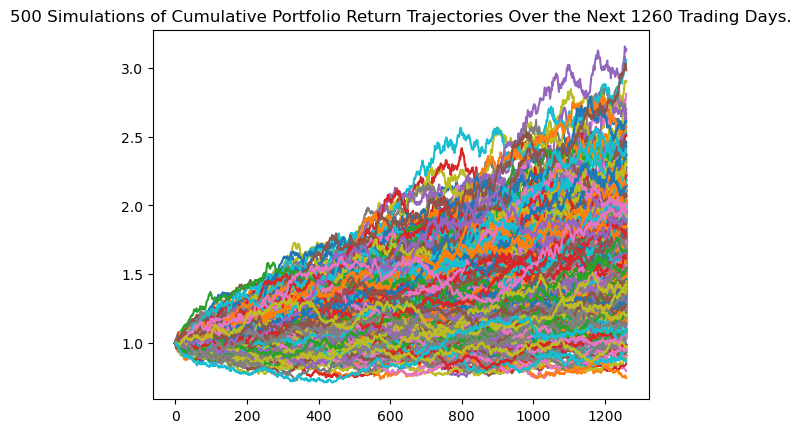

In [31]:
# Plot simulation outcomes
line_plot = MC_five_year.plot_simulation()

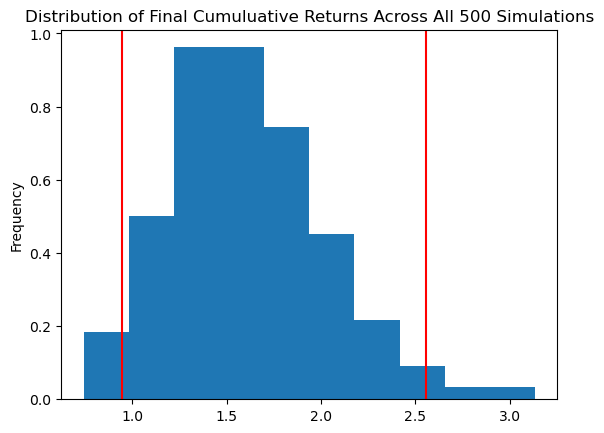

In [32]:
# Plot probability distribution and confidence intervals
dist_plot = MC_five_year.plot_distribution()

In [33]:
# Fetch and print summary statistics from the Monte Carlo simulation results
tbl = print_summary_stats(MC_five_year)

count           500.000000
mean              1.608955
std               0.406844
min               0.743815
25%               1.333512
50%               1.560515
75%               1.832426
max               3.134432
95% CI Lower      0.943764
95% CI Upper      2.557371
Name: 1260, dtype: float64


In [34]:
# Set initial investment
initial_investment = 60000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $60,000
# and Print results
process_ci(tbl,initial_investment,'5')


There is a 95% chance that an initial investment of $60,000 in the portfolio over the next 5 years will end within in the range of $56,625.87 and $153,442.26


### Ten Years Retirement Option

In [35]:
# Configuring a Monte Carlo simulation to forecast 10 years cumulative returns
MC_ten_year = configure_mc_simu(df_stock_data,10)

In [36]:
# Running a Monte Carlo simulation to forecast 10 years cumulative returns
MC_ten_year.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.995353,0.991100,1.002780,0.998958,0.995132,1.000237,1.003354,1.001561,1.000134,0.985716,...,0.992850,1.004532,0.994222,0.995182,1.013959,0.995239,1.008634,1.001753,1.011668,1.002577
2,0.993877,0.984221,1.001473,0.998887,0.995327,1.000806,0.990648,0.994878,1.008418,0.991177,...,1.001191,1.009175,1.002414,0.994857,1.015947,0.994425,1.004627,0.990803,1.012964,0.992572
3,0.990387,0.995008,1.000342,1.000126,0.996444,1.000887,0.982900,0.999492,1.004733,1.001348,...,1.003972,1.015068,1.002867,0.995939,1.021513,1.006621,0.992792,0.975076,1.021175,0.986255
4,0.987916,1.000377,1.002310,0.989571,1.003155,1.009089,0.989855,0.998482,1.019841,0.987311,...,0.989577,1.005341,1.008904,0.988676,1.020449,1.006812,0.990030,0.984281,1.027319,0.999553
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2516,2.554908,1.586661,2.126350,2.090447,2.938267,4.911328,1.307576,2.345130,1.408407,2.009835,...,2.605621,2.881938,2.443620,3.014871,3.067115,2.410558,4.407233,2.708491,1.359109,2.691052
2517,2.548840,1.581405,2.130909,2.096923,2.952849,4.887173,1.309208,2.328657,1.415163,1.996994,...,2.610891,2.881980,2.452109,3.000157,3.078549,2.414034,4.342339,2.702717,1.372101,2.698745
2518,2.551669,1.591990,2.164669,2.072158,2.972395,4.891595,1.310044,2.326731,1.426586,1.993387,...,2.623712,2.887316,2.445733,3.002692,3.083850,2.373431,4.345311,2.710505,1.369708,2.717164
2519,2.544902,1.593268,2.149870,2.088622,2.992358,4.871084,1.299215,2.342798,1.421765,1.998871,...,2.648018,2.882861,2.429199,2.993985,3.091017,2.393776,4.356992,2.724765,1.383564,2.750136


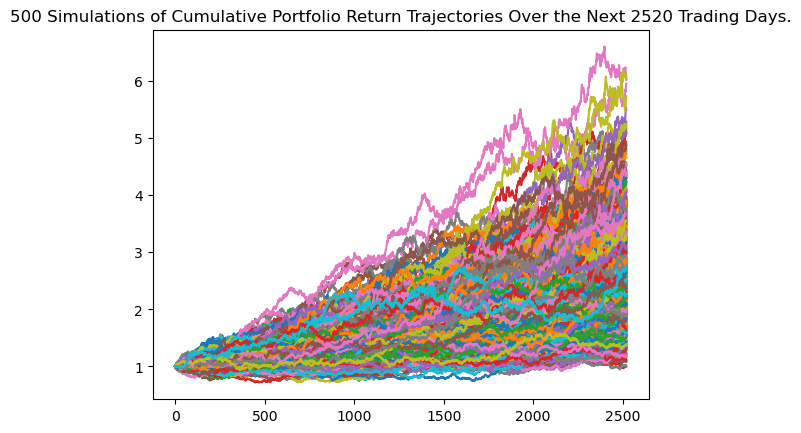

In [37]:
# Plot simulation outcomes
line_plot = MC_ten_year.plot_simulation()

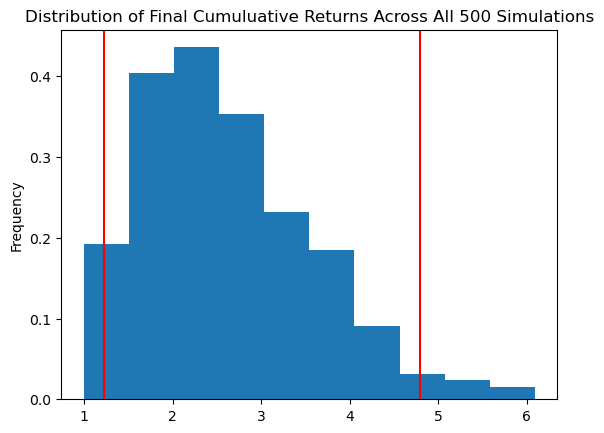

In [38]:
# Plot probability distribution and confidence intervals
dist_plot = MC_ten_year.plot_distribution()

In [39]:
# Fetch and print summary statistics from the Monte Carlo simulation results
tbl = print_summary_stats(MC_ten_year)

count           500.000000
mean              2.628875
std               0.955376
min               0.998908
25%               1.917361
50%               2.467946
75%               3.235220
max               6.093068
95% CI Lower      1.224942
95% CI Upper      4.793551
Name: 2520, dtype: float64


In [40]:
# Set initial investment
initial_investment = 60000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $60,000
# and print results
process_ci(tbl,initial_investment,'10')

There is a 95% chance that an initial investment of $60,000 in the portfolio over the next 10 years will end within in the range of $73,496.54 and $287,613.06
